# HW \#2
Imports and dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from scipy.stats import norm
from scipy.io import loadmat
from sklearn.cluster import KMeans

%matplotlib inline

## KMeans Clustering


In [2]:
# Load the matrix into memory, assuming for now that it is stored in the home directory
synth_all = pd.read_csv("../dataset/hw2/clustering/synth_all.csv")
synth_all.head()

,x1,x2
0,24.8697,14.6393
1,23.3448,16.4908
2,26.6545,22.6042
3,21.8222,27.1835
4,25.8840,6.3294


# 1. Data Inspection

### Part (a)
Visualize the training data

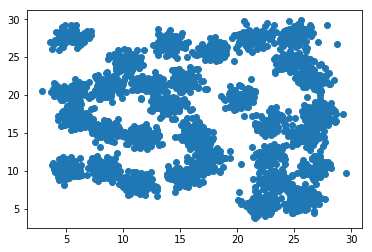

In [3]:
plt.scatter(synth_all.x1,synth_all.x2)

### Part (b)
There appear to be 31 clusters

## \#2 KMeans Fitting

In [4]:
def tune_kmeans_model(data, ks):
    """
    Initializes a len(ks) number of KMeans models and outputs the Baysian
    Information Criterion (bic) and Akaike Information Criterion (aic)
    for each setting of the parameters specified in the list ks. 
    """
    # Set the size of the input data
    n = data.shape[0]
    # intialize the returns
    bic = np.zeros(ks.shape)
    aic = np.zeros(ks.shape)
    for (i,k) in enumerate(ks):
        # fit the model to the data
        model = KMeans(n_clusters=k)
        model.fit(data)
        # compute the residual sum of squares
        cluster_idx = model.predict(data)
        rss = float(((synth_all - model.cluster_centers_[cluster_idx])**2).sum().sum())
        bic[i] = n*np.log(rss/n) + k*np.log(n)
        aic[i] = n*np.log(rss/n) + 2*k
    return bic, aic

In [5]:
ks = np.array(range(2,60))
bic,aic = tune_kmeans_model(synth_all, ks)

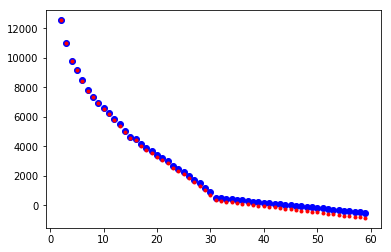

In [6]:
plt.plot(ks,bic,'bo',ks,aic,'r.')
plt.show()

## KNN Classification

In [7]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [8]:
synth_train = pd.read_csv("../dataset/hw2/clustering/synth_train.csv")
synth_valid = pd.read_csv("../dataset/hw2/clustering/synth_valid.csv")
synth_test = pd.read_csv("../dataset/hw2/clustering/synth_test.csv")
synth_train.head()

,x1,x2,y
0,7.8704,10.9570,3
1,6.0672,19.8695,5
2,21.8544,11.1640,27
3,16.1826,8.8962,13
4,9.1837,9.8484,3


In [9]:
def tune_knn_model(data, valid, ks):
    """
    Initializes a len(ks) number of KNN models and outputs the training and 
    classification accuracy for each setting of the parameters specified in 
    the list ks. 
    """
    # Set the sizes of the input data
    n_data = data.shape[0]
    n_valid = valid.shape[0]
    # initialize returns
    train_accuracy = np.zeros(ks.shape)
    valid_accuracy = np.zeros(ks.shape)
    for (i,k) in enumerate(ks):
        # Instantiate and train model
        model = KNN(n_neighbors=k)
        model.fit(data[['x1','x2']], data.y)
        # Predict labels on training data
        train_ys = model.predict(data[['x1','x2']])
        # Predict labels on validation data
        valid_ys = model.predict(valid[['x1','x2']])
        # Compute accuracy of training classifcation
        train_accuracy[i] = float(np.sum(np.equal(data.y, train_ys)))/n_data
        # Compute accuracy of validation classification
        valid_accuracy[i] = float(np.sum(np.equal(valid.y, valid_ys)))/n_valid
    return train_accuracy, valid_accuracy

In [10]:
ks = np.array(range(1,160))
tacc,vacc = tune_knn_model(synth_train, synth_valid, ks)

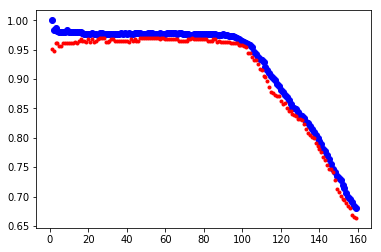

In [11]:
plt.plot(ks,tacc,'bo',ks,vacc,'r.')
plt.show()

It appears that a setting for $k$ from anywhere from $3$ to $\sim 105$ has good performance. Why does the performance degrade as $k$ gets larger?

In [12]:
# Here we chose k = 20
model = KNN(n_neighbors=20)
n = synth_test.shape[0]
model.fit(synth_train[['x1','x2']], synth_train.y)
ys = model.predict(synth_test[['x1','x2']])
accuracy = float(np.sum(np.equal(synth_test.y, ys)))/n
print('Classification accuracy on the test set: %f' % accuracy)

Classification accuracy on the test set: 0.979570


# Decision Tree Classification

In [13]:
red_train = pd.read_csv("../dataset/hw2/classification/red_train.csv")
red_valid = pd.read_csv("../dataset/hw2/classification/red_valid.csv")
red_test = pd.read_csv("../dataset/hw2/classification/red_test.csv")
red_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.1,0.63,0.06,2.0,0.083,8.0,29.0,0.99855,3.67,0.73,9.6,5
1,7.5,0.41,0.15,3.7,0.104,29.0,94.0,0.99786,3.14,0.58,9.1,5
2,5.6,0.66,0.00,2.2,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7
3,7.2,0.50,0.18,2.1,0.071,12.0,31.0,0.99761,3.52,0.72,9.6,6
4,7.2,0.63,0.00,1.9,0.097,14.0,38.0,0.99675,3.37,0.58,9.0,6


In [14]:
print("Number of datapoints in each set:\n\ttrain: %d\n\tvalid: %d\n\ttest: %d"
      % (red_train.shape[0], red_valid.shape[0], red_test.shape[0]))

Number of datapoints in each set:
	train: 895
	valid: 224
	test: 480


In [15]:
print("# features: %d" % red_train.columns.shape[0])

# features: 12


In [16]:
print("Averages for training set:\n\talcohol: %f\n\tpH: %f"
     % (np.mean(red_train.alcohol), np.mean(red_train.pH)))

Averages for training set:
	alcohol: 10.397952
	pH: 3.309542


Decision Tree Implementation

In [17]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [18]:
def tune_decision_tree_model(data, valid, ds, model_type=DTC):
    """
    Initializes a len(ds) number of binary decision tree models and outputs 
    the training and classification accuracy for each setting of the 
    parameters specified in the list ks. 
    """
    # Set the sizes of the input data
    n_data = data.shape[0]
    n_valid = valid.shape[0]
    # initialize returns
    train_accuracy = np.zeros(ds.shape)
    valid_accuracy = np.zeros(ds.shape)
    for (i,d) in enumerate(ds):
        # Train the model given the specified depth
        model = model_type(max_depth=d)
        features = data.columns.difference(['quality'])
        model.fit(data[features], data.quality)
        # Compute predicted labels for training and validation sets
        train_ys = model.predict(data[features])
        valid_ys = model.predict(valid[features])
        # Compute accuracy for training and validation sets
        train_accuracy[i] = float(np.sum(np.equal(data.quality, train_ys)))/n_data
        valid_accuracy[i] = float(np.sum(np.equal(valid.quality, valid_ys)))/n_valid
    return train_accuracy, valid_accuracy

In [19]:
ds = np.array(range(1,160))
tacc,vacc = tune_decision_tree_model(red_train, red_valid, ds)

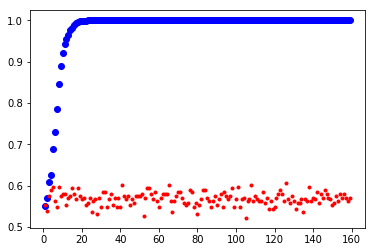

In [20]:
plt.plot(ds,tacc,'bo',ds,vacc,'r.')
plt.show()

This doesn't look that great! But it turns out that by leveraging a forest of such (relatively) poor decision trees, we can slightly improve the performance. 

In [21]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [22]:
ds = np.array(range(1,160))
tacc,vacc = tune_decision_tree_model(red_train, red_valid, ds, model_type = RFC)

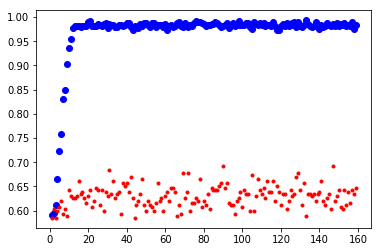

In [23]:
plt.plot(ds,tacc,'bo',ds,vacc,'r.')
plt.show()

In [24]:
# Here we chose d = 42
model = RFC(max_depth=42)
n = red_test.shape[0]
features = red_train.columns.difference(['quality'])
model.fit(red_train[features], red_train.quality)
ys = model.predict(red_test[features])
accuracy = float(np.sum(np.equal(red_test.quality, ys)))/n
print('Classification accuracy on the test set: %f' % accuracy)

Classification accuracy on the test set: 0.631250


# Logistic Regression

In [25]:
from sklearn.linear_model import SGDClassifier as LR

In [26]:
parkinsons_train = pd.read_csv("../dataset/hw2/log_reg/parkinsons_train.csv")
parkinsons_test = pd.read_csv("../dataset/hw2/log_reg/parkinsons_test.csv")
parkinsons_train.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,173.898,211.350,74.677,0.00448,0.00003,0.00237,0.00254,0.00710,0.06727,0.650,...,0.11363,0.04214,14.739,1,0.599371,0.743937,-5.783272,0.299793,3.007096,0.194052
1,119.100,128.442,88.833,0.00692,0.00006,0.00393,0.00300,0.01179,0.02682,0.236,...,0.04451,0.04611,21.824,1,0.651680,0.659333,-4.239028,0.175691,2.451130,0.247455
2,167.930,193.221,79.068,0.00442,0.00003,0.00220,0.00247,0.00661,0.04351,0.377,...,0.06685,0.01280,22.468,1,0.619060,0.679834,-4.330956,0.262384,2.916777,0.285695
3,158.219,442.557,71.948,0.00476,0.00003,0.00214,0.00207,0.00642,0.01458,0.148,...,0.01818,0.01554,26.356,1,0.450798,0.653823,-6.051233,0.273280,2.640798,0.170106
4,114.563,119.167,86.647,0.00327,0.00003,0.00146,0.00184,0.00439,0.01185,0.106,...,0.01672,0.00703,24.775,0,0.555303,0.659132,-6.710219,0.149694,1.913990,0.121777


In [27]:
features = parkinsons_train.columns.difference(['status'])
model = LR(learning_rate='optimal', loss='log', tol=1e-3, max_iter=1e6)
model.fit(parkinsons_train[features],parkinsons_train.status)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000000.0,
       n_iter=None, n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False)

In [28]:
n_train = parkinsons_train.shape[0]
n_test = parkinsons_test.shape[0]
train_ys = model.predict(parkinsons_train[features])
test_ys = model.predict(parkinsons_test[features])
tr_acc = float(np.sum(np.equal(parkinsons_train.status, train_ys)))/n_train
te_acc = float(np.sum(np.equal(parkinsons_test.status, test_ys)))/n_test

In [29]:
print("Training Accuracy: %f\nTesting Accuracy: %f" % (tr_acc, te_acc))

Training Accuracy: 0.250000
Testing Accuracy: 0.237288
